In [1]:
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time

from scipy import optimize
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.linalg import sqrtm

from mpl_toolkits.axes_grid1.inset_locator import inset_axes


np.set_printoptions(linewidth=np.inf)

#### parallelization 
options = qt.Options(num_cpus=6)


In [2]:

### Setup matplotlib

plt.rcParams.update({
    "text.usetex": True,
    "mathtext.fontset" : "stix",
    "font.family" : "Times New Roman", 
    "text.latex.preamble": r"\usepackage[T1]{fontenc} \usepackage{lmodern} \usepackage{amsmath} \usepackage{amstext}  \usepackage{amsfonts}",
    #
    "savefig.dpi" : 300,
    "xtick.minor.visible": True, 
    "ytick.minor.visible": True,
    
    "ytick.right": True,
    "ytick.left": True,

    "xtick.top": True,
    "xtick.bottom": True,
 
    #
    "xtick.direction": "in",
    "ytick.direction": "in",
    #
    "xtick.major.width": 1.5,     # major tick width in points
    "ytick.major.width": 1.5,     # major tick width in points
    #
    "xtick.minor.width": 1.5,     # minor tick width in points
    "ytick.minor.width": 1.5,     # minor tick width in points
    #
    "xtick.major.pad": 3.0,     # distance to major tick label in points
    "ytick.major.pad": 3.0,     # distance to major tick label in points
    #
    "xtick.minor.pad": 1.5,     # distance to the minor tick label in points
    "ytick.minor.pad": 1.5,     # distance to the minor tick label in points
    #
    "xtick.major.size": 3.0, 
    "ytick.major.size": 3.0,
    
    "xtick.minor.size": 3.0, 
    "ytick.minor.size": 3.0,
    #
    "xtick.labelsize": 20, 
    "ytick.labelsize": 20,
    #
    "legend.frameon": True, 
    "legend.fontsize": 20, 
    "legend.edgecolor": "black",
    "axes.titlesize": 20, 
    "axes.titleweight": "bold",
    "axes.labelsize":20 
})

##############
####### 
### Functions for evaluating the dominant eigenvalue

In [3]:


def Get_maximum(vector):
    """
    This function returns the maximum value and the corresponding index in a given vector.
    
    Parameters:
    vector: array-like 
        Input vector to search for the maximum value. 
    
    Returns: 
    max_value: float
        Maximum value found in the input vector.
    aux_idx: int
        Index of the maximum value in the input vector.
    """
    
    # Initialize variables for index and maximum value
    aux_idx = 0
    max_value = -np.Infinity
    
    # Enumerate through the vector, checking each value
    for idx, value in enumerate(vector):
        
        # If the current maximum value is greater than the real part of the current value
        if np.real(max_value) < np.real(value): 
            
            # Update the maximum value and the corresponding index
            max_value = value
            aux_idx = idx
            
    # Return the maximum value and its index
    return max_value, aux_idx



def Numeric_diagonalization(Ws, side="left"):
    """
    This function performs the numeric diagonalization of a given matrix, 
    returning the maximum eigenvalue and the corresponding eigenvector.

    Parameters:
    Ws: array-like
        Matrix to be diagonalized. 

    Returns:
    e_values[idx]: float
        Dominant (maximum) eigenvalue of the matrix.
    e_rightvectors[idx]: array-like
        Eigenvector corresponding to the dominant eigenvalue.
    """
    # Calculate the eigenvalues and left eigenvectors of the transpose of the input matrix
    if side == "left":
        e_values, e_vectors = np.linalg.eig(np.conjugate(Ws).T)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], np.conjugate(e_mat)
    elif side == "right":
        e_values, e_vectors = np.linalg.eig(Ws)
        # Get the maximum eigenvalue and its corresponding index
        dominant_e, idx = Get_maximum(e_values)

        # Get dimension
        d = int(np.sqrt(np.shape(Ws)[0]))
    
        # reshaping the result
        e_mat = np.reshape(e_vectors[:,idx], (d,d))
        
        # Return the dominant eigenvalue and corresponding (left or right) eigen matrix
        return e_values[idx], e_mat/np.trace(e_mat)
        
    else: raise ValueError('You have to choose or left or right')

###############
####### Coding 
###############

In [4]:
def entropy_prod_current(t, jump, args):
    ### if hot bath

    if jump == 0:  # |0><1| 
        return -args["beta_h"](t, args)*(args["omega"] - args["Omega"])
    elif jump == 1:# |1><0|
        return args["beta_h"](t, args)*(args["omega"] - args["Omega"])
    elif jump == 2:# |0><2|
        return -args["beta_h"](t, args)*(args["omega"] + args["Omega"])
    elif jump == 3:# |2><0|
        return args["beta_h"](t, args)*(args["omega"] + args["Omega"])
    elif jump == 4:# |1><3|
        return -args["beta_h"](t, args)*(args["omega"] + args["Omega"])
    elif jump == 5:# |3><1|
        return args["beta_h"](t, args)*(args["omega"] + args["Omega"])
    elif jump == 6:# |2><3|
        return -args["beta_h"](t, args)*(args["omega"] - args["Omega"])
    elif jump == 7:# |3><2|
        return args["beta_h"](t, args)*(args["omega"] - args["Omega"])
    
    ### if cold bath

    elif jump == 8:# |0><1|
        return -args["beta0_c"]*(args["omega"] - args["Omega"])
    elif jump == 9:# |1><0|
        return args["beta0_c"]*(args["omega"]  - args["Omega"])
    elif jump == 10:# |0><2|
        return -args["beta0_c"]*(args["omega"] + args["Omega"])
    elif jump == 11:# |2><0|
        return args["beta0_c"]*(args["omega"] + args["Omega"])
    elif jump == 12:# |1><3|
        return -args["beta0_c"]*(args["omega"] + args["Omega"])
    elif jump == 13:# |3><1|
        return args["beta0_c"]*(args["omega"] + args["Omega"])
    elif jump == 14:# |2><3|
        return -args["beta0_c"]*(args["omega"] - args["Omega"])
    elif jump == 15:# |3><2|
        return args["beta0_c"]*(args["omega"] - args["Omega"])
    
    
    
#def organize_jumps(col_times, col_which, Nboxes, args):
#    # Set dt
#    dt = args["tau"]/(Nboxes)
#    # Initialize N empty arrays
#    times = [[] for _ in range(Nboxes)]
#    jumps = [[] for _ in range(Nboxes)]
#    entropy_current = [0 for _ in range(Nboxes)]
#    
#    # Organize time instants into arrays
#    for i, t in enumerate(col_times):
#        n = int(t // dt)
#        times[n].append(t)
#        jumps[n].append(col_which[i])
#        entropy_current[n] += entropy_prod_current(t, col_which[i], args)
#    return times, jumps, np.array(entropy_current)/dt

def Trott_organize_jumps(col_times, col_which, Nboxes, args):
    # Initialize empty array
    dt = args["tau"]/(Nboxes)
    
    entropy_current = [0 for _ in range(Nboxes)]
    
    # Organize time instants into arrays
    for i, col_list in enumerate(col_which):
        for j, col in enumerate(col_list):
            entropy_current[i] += entropy_prod_current(col_times[i][j], col, args)
    print(entropy_current)
    return np.array(entropy_current)/dt

In [5]:
########## Rates 

##### hot bath
def J_01_h_rate(t, args): 
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))) ) 
    
def J_10_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_h_rate(t, args):
    return (np.sqrt(args["alpha_h"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta_h"](t, args) * (args["omega"] - args["Omega"])) - 1))))
    
##### cold bath
    
def J_01_c_rate(t, args): 
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))) ) 

def J_10_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1)))) 
    
def J_02_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_20_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1))))     
    
def J_13_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1))))
    
def J_31_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] + args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] + args["Omega"])) - 1)))) 
    
def J_23_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (1 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))))
       
def J_32_c_rate(t, args):
    return (np.sqrt(args["alpha_c"] * (args["omega"] - args["Omega"]) ** 3 
                    * (0 + 1 / (np.exp(args["beta0_c"] * (args["omega"] - args["Omega"])) - 1))))
    


In [6]:
def DualSuperOperator_Lindbladian(O, t, H0, cops, args):
    """
        Code for checking if the left eigenmatrix is the actual one 
    """
    omega = args["omega"]
    Omega = args["Omega"]
    s = args["s_func"](t, args)
    print(s)

    bh = args["beta_h"](t, args)
    bc = args["beta0_c"]

    #for c in cops:
    #    Heff -= 0.5j * c.dag() * c
    dO = 1.0j*( H0 * O - O * H0)
    
    for i, c in enumerate(cops):
        dO += (np.exp(-args["s_func"](t, args)*entropy_prod_current(t, i, args)) * c.dag() * O * c 
               -  0.5 * (c.dag() * c * O + O * c.dag() * c) )
    return dO 

In [13]:
#Ls = Tilted_lindbladian(args["tau"]/2, H0, [c[0]*c[1](args["tau"]/2, args) for c in c_ops_list], args)
#lambda0, l0 = Numeric_diagonalization(Ls, side="left")

#ll0 = DualSuperOperator_Lindbladian(np.conjugate(l0), args["tau"]/2, H0, [c[0]*c[1](args["tau"]/2, args) for c in c_ops_list], args)


In [14]:
def Tilted_lindbladian(t, H0, cops, args):
    
    omega = args["omega"]
    Omega = args["Omega"]
    s = args["s_func"](t, args)
    bh = args["beta_h"](t, args)
    bc = args["beta0_c"]

    
    Ide = qt.tensor(qt.qeye(2), qt.qeye(2))

    Flat_H0  = -1.0j*(qt.tensor(Ide, H0) - qt.tensor(H0.trans(), Ide)).full()
     
    J_01_h, J_10_h, J_02_h, J_20_h, J_13_h, J_31_h, J_23_h, J_32_h = cops[0:8]
    J_01_c, J_10_c, J_02_c, J_20_c, J_13_c, J_31_c, J_23_c, J_32_c = cops[8:]
    
    ########### Flattening the operators 
    Ide = qt.tensor(qt.qeye(2), qt.qeye(2))

    ####### Non-hermitian evolution 
    ## hot bath
    
    Flat_J_01_h = -(1.0/2.0)*(qt.tensor(Ide, J_01_h.dag()*J_01_h) + qt.tensor((J_01_h.dag()*J_01_h).trans(), Ide)).full()
    Flat_J_02_h = -(1.0/2.0)*(qt.tensor(Ide, J_02_h.dag()*J_02_h) + qt.tensor((J_02_h.dag()*J_02_h).trans(), Ide)).full()
    Flat_J_13_h = -(1.0/2.0)*(qt.tensor(Ide, J_13_h.dag()*J_13_h) + qt.tensor((J_13_h.dag()*J_13_h).trans(), Ide)).full()
    Flat_J_23_h = -(1.0/2.0)*(qt.tensor(Ide, J_23_h.dag()*J_23_h) + qt.tensor((J_23_h.dag()*J_23_h).trans(), Ide)).full()

    Flat_J_10_h = -(1.0/2.0)*(qt.tensor(Ide, J_10_h.dag()*J_10_h) + qt.tensor((J_10_h.dag()*J_10_h).trans(), Ide)).full()
    Flat_J_20_h = -(1.0/2.0)*(qt.tensor(Ide, J_20_h.dag()*J_20_h) + qt.tensor((J_20_h.dag()*J_20_h).trans(), Ide)).full()
    Flat_J_31_h = -(1.0/2.0)*(qt.tensor(Ide, J_31_h.dag()*J_31_h) + qt.tensor((J_31_h.dag()*J_31_h).trans(), Ide)).full()
    Flat_J_32_h = -(1.0/2.0)*(qt.tensor(Ide, J_32_h.dag()*J_32_h) + qt.tensor((J_32_h.dag()*J_32_h).trans(), Ide)).full()

    ## cold bath
    Flat_J_01_c = -(1.0/2.0)*(qt.tensor(Ide, J_01_c.dag()*J_01_c) + qt.tensor((J_01_c.dag()*J_01_c).trans(), Ide)).full()
    Flat_J_02_c = -(1.0/2.0)*(qt.tensor(Ide, J_02_c.dag()*J_02_c) + qt.tensor((J_02_c.dag()*J_02_c).trans(), Ide)).full()
    Flat_J_13_c = -(1.0/2.0)*(qt.tensor(Ide, J_13_c.dag()*J_13_c) + qt.tensor((J_13_c.dag()*J_13_c).trans(), Ide)).full()
    Flat_J_23_c = -(1.0/2.0)*(qt.tensor(Ide, J_23_c.dag()*J_23_c) + qt.tensor((J_23_c.dag()*J_23_c).trans(), Ide)).full()

    Flat_J_10_c = -(1.0/2.0)*(qt.tensor(Ide, J_10_c.dag()*J_10_c) + qt.tensor((J_10_c.dag()*J_10_c).trans(), Ide)).full()
    Flat_J_20_c = -(1.0/2.0)*(qt.tensor(Ide, J_20_c.dag()*J_20_c) + qt.tensor((J_20_c.dag()*J_20_c).trans(), Ide)).full()
    Flat_J_31_c = -(1.0/2.0)*(qt.tensor(Ide, J_31_c.dag()*J_31_c) + qt.tensor((J_31_c.dag()*J_31_c).trans(), Ide)).full()
    Flat_J_32_c = -(1.0/2.0)*(qt.tensor(Ide, J_32_c.dag()*J_32_c) + qt.tensor((J_32_c.dag()*J_32_c).trans(), Ide)).full()

    
    Flat_Inc_h = (Flat_J_01_h + Flat_J_02_h + Flat_J_13_h + Flat_J_23_h
                + Flat_J_10_h + Flat_J_20_h + Flat_J_31_h + Flat_J_32_h)

    Flat_Inc_c = (Flat_J_01_c + Flat_J_02_c + Flat_J_13_c + Flat_J_23_c
                + Flat_J_10_c + Flat_J_20_c + Flat_J_31_c + Flat_J_32_c)

    ####### Jumps 
    # hot bath
    Flat_jump_J_01_h = (qt.tensor(J_01_h.conj(),J_01_h)).full()
    Flat_jump_J_02_h = (qt.tensor(J_02_h.conj(),J_02_h)).full()
    Flat_jump_J_13_h = (qt.tensor(J_13_h.conj(),J_13_h)).full()
    Flat_jump_J_23_h = (qt.tensor(J_23_h.conj(),J_23_h)).full()

    Flat_jump_J_10_h = (qt.tensor(J_10_h.conj(),J_10_h)).full()
    Flat_jump_J_20_h = (qt.tensor(J_20_h.conj(),J_20_h)).full()
    Flat_jump_J_31_h = (qt.tensor(J_31_h.conj(),J_31_h)).full()
    Flat_jump_J_32_h = (qt.tensor(J_32_h.conj(),J_32_h)).full()
    
    #cold bath
    Flat_jump_J_01_c = (qt.tensor(J_01_c.conj(),J_01_c)).full()
    Flat_jump_J_02_c = (qt.tensor(J_02_c.conj(),J_02_c)).full()
    Flat_jump_J_13_c = (qt.tensor(J_13_c.conj(),J_13_c)).full()
    Flat_jump_J_23_c = (qt.tensor(J_23_c.conj(),J_23_c)).full()

    Flat_jump_J_10_c = (qt.tensor(J_10_c.conj(),J_10_c)).full()
    Flat_jump_J_20_c = (qt.tensor(J_20_c.conj(),J_20_c)).full()
    Flat_jump_J_31_c = (qt.tensor(J_31_c.conj(),J_31_c)).full()
    Flat_jump_J_32_c = (qt.tensor(J_32_c.conj(),J_32_c)).full()

    Flat_Jump_h = (  np.exp(+s*(omega-Omega)*bh)*Flat_jump_J_01_h 
                   + np.exp(+s*(omega+Omega)*bh)*Flat_jump_J_02_h 
                   + np.exp(+s*(omega+Omega)*bh)*Flat_jump_J_13_h 
                   + np.exp(+s*(omega-Omega)*bh)*Flat_jump_J_23_h

                   + np.exp(-s*(omega-Omega)*bh)*Flat_jump_J_10_h 
                   + np.exp(-s*(omega+Omega)*bh)*Flat_jump_J_20_h 
                   + np.exp(-s*(omega+Omega)*bh)*Flat_jump_J_31_h 
                   + np.exp(-s*(omega-Omega)*bh)*Flat_jump_J_32_h)

    Flat_Jump_c = (  np.exp(+s*(omega-Omega)*bc)*Flat_jump_J_01_c 
                   + np.exp(+s*(omega+Omega)*bc)*Flat_jump_J_02_c 
                   + np.exp(+s*(omega+Omega)*bc)*Flat_jump_J_13_c 
                   + np.exp(+s*(omega-Omega)*bc)*Flat_jump_J_23_c

                   + np.exp(-s*(omega-Omega)*bc)*Flat_jump_J_10_c 
                   + np.exp(-s*(omega+Omega)*bc)*Flat_jump_J_20_c 
                   + np.exp(-s*(omega+Omega)*bc)*Flat_jump_J_31_c 
                   + np.exp(-s*(omega-Omega)*bc)*Flat_jump_J_32_c)

    Lst = Flat_H0 + Flat_Inc_h + Flat_Jump_h + Flat_Inc_c + Flat_Jump_c     

    return Lst.astype(complex)




In [15]:
def Doob_system(H0, c_ops, t, args):
        
    #### Tilted Lindbladian 
    Ls = Tilted_lindbladian(t, H0, c_ops, args)
    lambda0, l0 = Numeric_diagonalization(Ls, side="left")
        
    #### Non-hermitian term of the deterministic evolution
        
    Heff = H0.copy()
    for c in c_ops:
        Heff -= 0.5j * c.dag() * c
            
    #### Calculating the Doob

    l0sqr = qt.Qobj(l0, dims=[[2, 2], [2, 2]]).sqrtm()
    Heff = l0sqr * Heff * l0sqr.inv()

    Heff = 0.5*(Heff + Heff.dag())
    Jauxlist = []
    for j, c in enumerate(c_ops):
        rotated_operator = l0sqr*c*l0sqr.inv()
        rotated_rate = np.exp(-args["s_func"](t, args)*entropy_prod_current(t, j, args)/2)
        Jauxlist.append(rotated_rate*rotated_operator)
            
    return Heff, Jauxlist

In [16]:
def OneTrajectory(H0, c_ops, psi, tlist, args):
    jumps = []
    times = []

    dt = tlist[1]-tlist[0]
    for i, t in enumerate(tlist):
        print(t)
        aux_tlist = np.linspace((i+1)*dt, (i+2)*dt, 1000)
        aux_c_ops = [j[0]*(j[1](t, args)) for j in c_ops]
        Haux, Jaux = Doob_system(H0, aux_c_ops, t, args)
        result = qt.mcsolve(Haux, psi, aux_tlist, Jaux, args=args, ntraj=1)

        jumps.append(result.col_which[0])
        times.append(result.col_times[0])

        psi = result.states[0][-1]
    return jumps, times

In [17]:
# Define the states
ket00 = qt.tensor(qt.basis(2,1), qt.basis(2,1))
ket01 = qt.tensor(qt.basis(2,1), qt.basis(2,0))
ket10 = qt.tensor(qt.basis(2,0), qt.basis(2,1))
ket11 = qt.tensor(qt.basis(2,0), qt.basis(2,0))

sigmam_h = qt.tensor(qt.sigmam(), qt.qeye(2))
sigmam_c = qt.tensor(qt.qeye(2), qt.sigmam())
sigmap_h = qt.tensor(qt.sigmap(), qt.qeye(2))
sigmap_c = qt.tensor(qt.qeye(2), qt.sigmap())

sigmax_h = qt.tensor(qt.sigmax(), qt.qeye(2))
sigmax_c = qt.tensor(qt.qeye(2), qt.sigmax())

sigmaz_h = qt.tensor(qt.sigmaz(), qt.qeye(2))
sigmaz_c = qt.tensor(qt.qeye(2), qt.sigmaz())

eps0 = ket00
eps1 = np.sqrt(1/2)*(ket01 - ket10)
eps2 = np.sqrt(1/2)*(ket01 + ket10)
eps3 = ket11
    
##### Transitions 
    
J_01 = eps0 * eps1.dag()
    
J_10 = eps1 * eps0.dag() 
        
J_02 = eps0 * eps2.dag()
    
J_20 = eps2 * eps0.dag()
    
J_13 = eps1 * eps3.dag()

J_31 = eps3 * eps1.dag()

J_23 = eps2 * eps3.dag()
    
J_32 = eps3 * eps2.dag()


In [18]:
#####
# Putting it into a list 
    
c_ops_list = [[J_01, J_01_h_rate], 
             [J_10, J_10_h_rate],
             [J_02, J_02_h_rate],  
             [J_20, J_20_h_rate],
             [J_13, J_13_h_rate],
             [J_31, J_31_h_rate], 
             [J_23, J_23_h_rate], 
             [J_32, J_32_h_rate], 
#####################################
             [J_01, J_01_c_rate],
             [J_10, J_10_c_rate], 
             [J_02, J_02_c_rate],
             [J_20, J_20_c_rate],
             [J_13, J_13_c_rate],
             [J_31, J_31_c_rate],
             [J_23, J_23_c_rate],
             [J_32, J_32_c_rate]]


In [28]:
####### Parameters 

omega = 1.0
alpha_h = 1.0
alpha_c = 1.0
beta0_h = 1.0/(2.0) # T = 2
beta_c = 1.0/(1.0) # T = 1
Omega = 0.5
g = 1.0

def s_func(t, args):
    #return np.tanh(2*t/args["tau"] - 1)
    return -0.25

def beta_h(t, args):
    return 1/(1/args["beta0_h"] + np.sin(t*np.pi/args["tau"])**2)


############# Total dynamics time


tau = 100*1000

############# Argumets dict 

args  = {"omega":omega,
         "Omega":Omega,
         "g":g,
         "alpha_h":alpha_h,
         "alpha_c":alpha_c,
         "beta_h":beta_h,
         "beta0_h":beta0_h,
         "beta0_c":beta_c,
         "tau":tau,
         "s_func":s_func }

In [29]:
####### Hamiltonian    
    
H0 = (Omega*( sigmam_h*sigmap_c + sigmap_h*sigmam_c) 
        + g*(sigmax_c + sigmax_h) 
        + (omega/2)*(sigmaz_c + sigmaz_h))

####### Initial state

psi0 = ket00.copy()

####### Time window 
Nsteps = 100
tlist = np.linspace(0, tau, Nsteps)

In [30]:
jumps, times =  OneTrajectory(H0, c_ops_list, psi0, tlist, args)

0.0
Total run time:   0.89s
1010.10101010101
Total run time:   0.87s
2020.20202020202
Total run time:   0.92s
3030.30303030303
Total run time:   0.88s
4040.40404040404
Total run time:   0.87s
5050.50505050505
Total run time:   0.89s
6060.60606060606
Total run time:   0.88s
7070.707070707071
Total run time:   0.87s
8080.80808080808
Total run time:   0.91s
9090.90909090909
Total run time:   0.93s
10101.0101010101
Total run time:   0.90s
11111.111111111111
Total run time:   0.94s
12121.21212121212
Total run time:   0.90s
13131.31313131313
Total run time:   0.92s
14141.414141414141
Total run time:   0.94s
15151.51515151515
Total run time:   0.95s
16161.61616161616
Total run time:   0.95s
17171.71717171717
Total run time:   0.95s
18181.81818181818
Total run time:   0.96s
19191.91919191919
Total run time:   1.00s
20202.0202020202
Total run time:   0.99s
21212.121212121212
Total run time:   1.00s
22222.222222222223
Total run time:   1.06s
23232.32323232323
Total run time:   1.00s
24242.424242

In [31]:
ent = Trott_organize_jumps(times, jumps, Nsteps, args)

[-242.91561648627254, -275.4989297805413, -195.95543732842202, -179.41675360090275, -227.42605236767335, -266.3427792274814, -250.2093934404622, -177.65130161878005, -294.9658280241677, -308.69644448399873, -253.02343867045997, -232.18892118099996, -219.33523934724516, -242.1425920408642, -299.50579699094317, -296.3700250102456, -296.7647992026526, -327.28732060121683, -354.6638714059298, -294.73256601954716, -330.0917265220361, -268.68954902551695, -448.0522242118217, -333.11472014793975, -327.09687318948005, -355.72219457726385, -380.50682541893997, -305.9062076762831, -413.56858555874186, -361.572151911136, -275.74779847083425, -312.6515052945869, -310.25830692360387, -374.25798401491346, -384.14746474846345, -281.4215619990573, -358.3493468407716, -442.24758605924467, -382.1913987556931, -392.2350884822689, -422.90696333949455, -384.43505292429097, -436.41893614546655, -346.8695246129346, -381.2526680617117, -424.9415956206407, -444.5665755587871, -377.4421060063358, -321.995066178

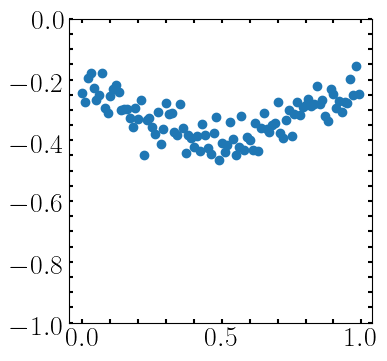

In [32]:
fig, ax = plt.subplots(1,1, figsize=(7, 3.5), 
                       layout='compressed')

ax.scatter(np.arange(Nsteps)/Nsteps, ent)

ax.set_ylim(-1,0)

ax.set_box_aspect(1)


# Activity in a path

I have to calculate the value of the derivative for each time interval, then see in each point in $s(t)$

In [33]:
############# Get scaled cumulant generating function





def f(H0, cops, tlist, slist, args):
    grid = np.zeros((len(tlist), len(slist)))

    for i, t in enumerate(tlist):
        aux_cops = [c[0]*c[1](t, args) for c in cops]
        for j, s in enumerate(slist):
            args["s_func"] = lambda t, args: s
            e_val, e_vec =  Numeric_diagonalization(Tilted_lindbladian(t, H0, aux_cops, args), side="right")
            grid[i][j] = np.real(e_val)
            
    return grid.real  

############# Get activities for a trajectory

def get_activities(H0, cops, slist, tlist, args):
    flist = f(H0, cops, tlist, slist, args)
    # Compute the Legendre transform for each k
    return -np.gradient(flist, slist, edge_order=2)

In [36]:
Slen = 1000
Tlen = 20

slist = np.linspace(-0.25-0.001, -0.25+0.001, Slen)
tlist = np.linspace(0, args["tau"], Tlen)

grid = f(H0, c_ops_list, tlist, slist, args)

In [37]:
activities = -np.gradient(grid, slist[1]-slist[0],  edge_order=2, axis=1)

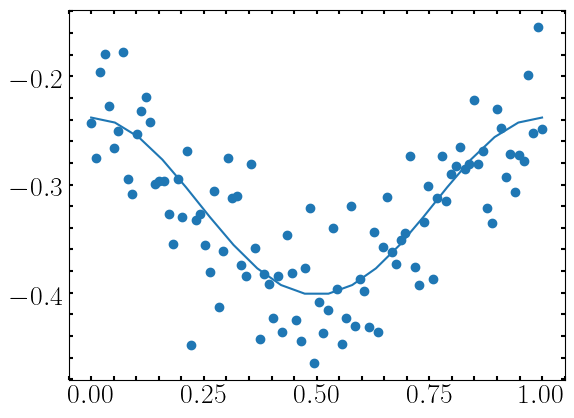

In [38]:
plt.scatter(np.linspace(0, Nsteps, Nsteps)/(Nsteps), ent)

plt.plot(tlist/args["tau"], activities[:,int(Slen/2)])


#plt.ylim((-1,0))

Text(0, 0.5, '$s$')

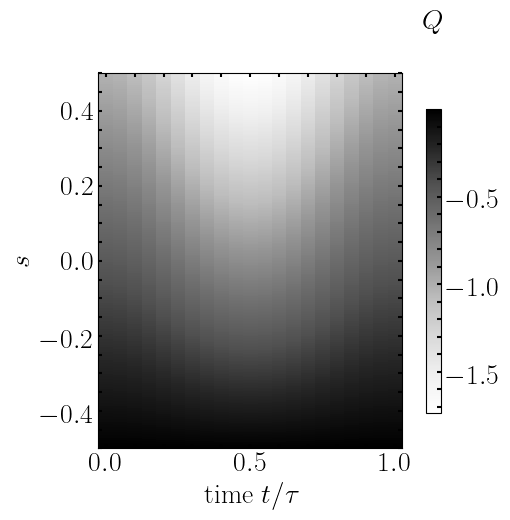

In [181]:

S, T = np.meshgrid(slist, tlist/args["tau"])
# Plot the original function and its Legendre transform
fig, ax = plt.subplots(1,1,figsize=(5, 5), 
                       layout='compressed')


cbar = ax.pcolormesh(T, S, activities.real, cmap="Greys",rasterized=True)
cbar1 = fig.colorbar(cbar, ax=ax, pad=.05, fraction=0.05,  orientation='vertical')
cbar1.ax.set_xlabel(r"$Q$", labelpad=-290, va='top')



ax.set_xlabel(r"time $t/\tau$")
ax.set_ylabel(r"$s$")

In [86]:
Nintervals = 100

#slist = np.tanh((np.linspace(0, 1, Nintervals)-0.5))
slist = np.linspace(-1, 1, Nintervals)
tlist = np.linspace(0, args["tau"], Nintervals)


grid = f(H0, c_ops, tlist, slist, Nintervals, args)

/var/folders/lv/nmcn0_7s3sv_bdldgwhvxr_40000gn/T/ipykernel_42338/927238154.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  res[i][j] = e_val


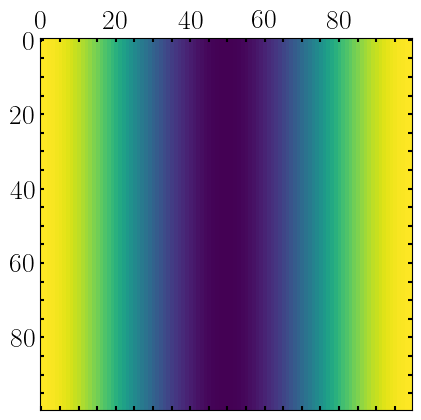

In [87]:
plt.matshow(grid)

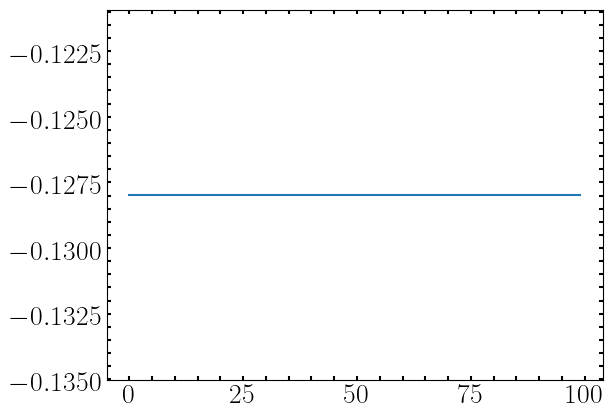

In [100]:
plt.plot(grid.T[10])

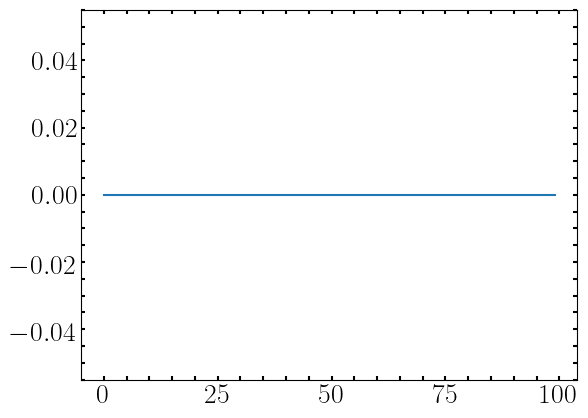

In [93]:
plt.plot(-np.gradient(grid.T, slist, axis=1)[50)

In [119]:
ntraj=1000
result = qt.mcsolve(H0, psi0, tlist, c_ops, args=args, ntraj=2)

50.0%. Run time: 274.34s. Est. time left: 00:00:04:34
100.0%. Run time: 277.07s. Est. time left: 00:00:00:00
Total run time: 277.08s


In [122]:
result.col_times[0]

array([1.29226153e-02, 2.44614240e-01, 3.75737287e-01, ...,
       9.99959316e+03, 9.99975289e+03, 9.99977600e+03])

In [125]:
Nboxes = 10

entropy_data = []
for traj in range(2):
    times, jumps, entropy = organize_jumps(result.col_times[traj], result.col_which[traj], Nboxes, args)
    entropy_data.append(entropy)
    
entropy_data = np.array(entropy_data)

mean_values = np.mean(np.array(entropy_data).T, axis=1)
std_dev_values = np.std(np.array(entropy_data).T, axis=1)


In [ ]:
#np.savetxt("EntropyPC_5000trajs_meanvalue.txt", mean_values)
#np.savetxt("EntropyPC_5000trajs_std.txt", std_dev_values)


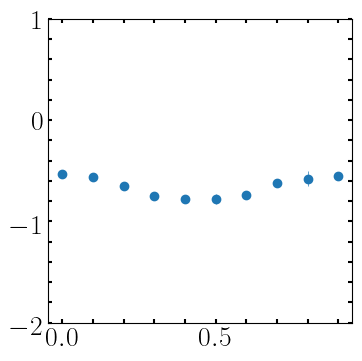

In [179]:

fig, ax = plt.subplots(1,1, figsize=(7, 3.5), 
                       layout='compressed')

ax.errorbar( np.arange(Nboxes)/Nboxes, mean_values, yerr=std_dev_values,  elinewidth=0.5, fmt="o")
ax.set_ylim(-2,1)


ax.set_box_aspect(1)



In [177]:
result.col_times[0]

array([1.29226153e-02, 2.44614240e-01, 3.75737287e-01, ...,
       9.99959316e+03, 9.99975289e+03, 9.99977600e+03])

Text(0.5, 0, '$\\sigma$')

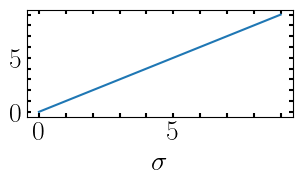

In [178]:
fig = plt.figure(figsize=(247 / 72, 100 /72))

plt.plot(np.arange(10))
plt.xlabel(r"$\sigma$")